## NLP Analysis of Tweets Project - Adam Horvath-Reparszky

### Import libraries

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import re
import string
import random

#Language processing
from nltk.corpus import stopwords, words # get stopwords from NLTK library & get all words in english language
from nltk.tokenize import word_tokenize # to create word tokens

from nltk.stem import WordNetLemmatizer # to reduce words to orginal form
import emoji

from wordcloud import WordCloud # WordCloud - Python linrary for creating image wordclouds
from PIL import Image

#modeling part
from sklearn.model_selection import train_test_split
from transformers import DistilBertTokenizerFast
from transformers import TFDistilBertForSequenceClassification
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy

### Load data

In [2]:
df_tweets = pd.read_csv('data/train.csv') #loading train data from csv
test_tweets = pd.read_csv('data/test.csv') #loading test data from csv
df_tweets.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [3]:
df_tweets.duplicated(subset='id').sum() # Check for duplicate values

0

In [4]:
df_tweets.isna().any() # Check for "NaN" values

id          False
keyword      True
location     True
text        False
target      False
dtype: bool

In [5]:
df_tweets['location']=df_tweets['location'].fillna('No location') # Replace "NaN" values with "No Location"
df_tweets['keyword']=df_tweets['keyword'].fillna('No keyword') # Replace "NaN" values with "No keyword"

In [6]:
df_tweets.isna().any() # Check for "NaN" values again to double check

id          False
keyword     False
location    False
text        False
target      False
dtype: bool

In [7]:
#cheking the shape of the two dataframe
print('There are {} rows and {} columns in train'.format(df_tweets.shape[0],df_tweets.shape[1]))
print('There are {} rows and {} columns in train'.format(test_tweets.shape[0],test_tweets.shape[1]))

There are 7613 rows and 5 columns in train
There are 3263 rows and 4 columns in train


### Data Visualization

* Let's check first the **class distribution**

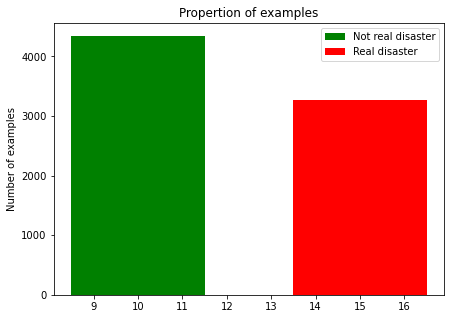

In [8]:
Real_len = df_tweets[df_tweets['target'] == 1].shape[0] #number of real tweets
Not_len = df_tweets[df_tweets['target'] == 0].shape[0] #number of tweets that are not
plt.rcParams['figure.figsize'] = (7, 5)
plt.bar(10,Not_len,3, label="Not real disaster", color='green')
plt.bar(15,Real_len,3, label="Real disaster", color='red')
plt.legend()
plt.ylabel('Number of examples')
plt.title('Propertion of examples')
plt.show()

**Conclusion** : There are more tweets in the class of not real disaster, but the difference is not significant.

* Analyzing **number of characters** in tweets 

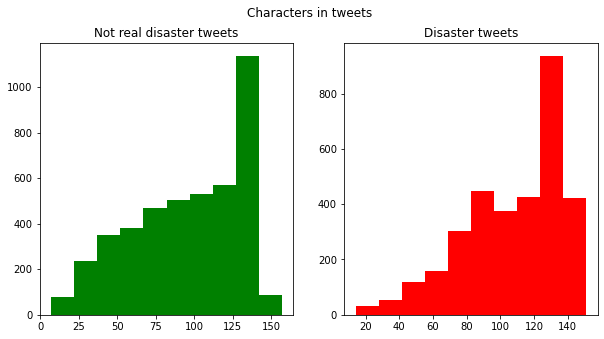

In [9]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(10,5))
tweet_len=df_tweets[df_tweets['target']==0]['text'].str.len()
ax1.hist(tweet_len,color='green')
ax1.set_title('Not real disaster tweets')
fig.suptitle('Characters in tweets')
tweet_len=df_tweets[df_tweets['target']==1]['text'].str.len()
ax2.hist(tweet_len,color='red')
ax2.set_title('Disaster tweets')
plt.show()

**Conclusion**: The distribution of both classes are almost the same, number of characters between 120-140 are the most common.

* Analyze the **number of words** in a tweet

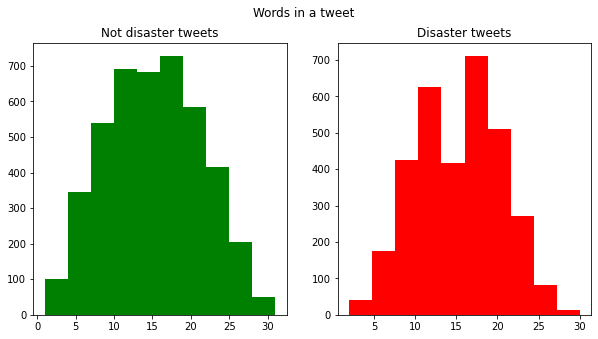

In [10]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(10,5))
tweet_len=df_tweets[df_tweets['target']==0]['text'].str.split().map(lambda x: len(x))
ax1.hist(tweet_len,color='green')
ax1.set_title('Not disaster tweets')
tweet_len=df_tweets[df_tweets['target']==1]['text'].str.split().map(lambda x: len(x))
ax2.hist(tweet_len,color='red')
ax2.set_title('Disaster tweets')
fig.suptitle('Words in a tweet')
plt.show()

### Tweet Processing

In [11]:
# preprocessTweets is a function to remove punctuations, links, emojis, and stop words
def preprocessTweets(tweet):
    tweet = tweet.lower()  #has to be in place - make it lowercase
    tweet = re.sub(r"http\S+|www\S+|https\S+", '', tweet, flags=re.MULTILINE) # Remove urls
    tweet = re.sub(r'\@\w+|\#|\d+', '', tweet) # Remove user @ references and '#' from tweet
    
    # Remove stopwords
    tweet_tokens = word_tokenize(tweet)  # convert string to tokens
    filtered_words = [w for w in tweet_tokens if w not in stop_words]
    filtered_words = [w for w in filtered_words if w not in emojis]

    # Remove punctuations
    unpunctuated_words = [char for char in filtered_words if char not in string.punctuation]
    unpunctuated_words = ' '.join(unpunctuated_words)

    return "".join(unpunctuated_words)  #the output of this function are words with a space in between them!

In [12]:
stop_words = list(stopwords.words('english'))
#user_stop_words = [] in this list we can specify customized words we want to remove
alphabets = list(string.ascii_lowercase)
stop_words = stop_words + alphabets #+ user_stop_words
emojis = list(emoji.UNICODE_EMOJI['en'].keys())  #list of emojis

In [13]:
df_tweets['Processed_Tweets'] = df_tweets['text'].apply(preprocessTweets)

In [14]:
def preprocessTweetsLemmatizer(tweet):
    tweet_tokens = word_tokenize(tweet)
    lemmatizer = WordNetLemmatizer() # instatiate an object WordNetLemmatizer Class
    lemma_words = [lemmatizer.lemmatize(w) for w in tweet_tokens]
    return " ".join(lemma_words)

In [15]:
df_tweets['Processed_Tweets'] = df_tweets['Processed_Tweets'].apply(preprocessTweetsLemmatizer)

In [16]:
df_tweets.head()

,id,keyword,location,text,target,Processed_Tweets
0,1,No keyword,No location,Our Deeds are the Reason of this #earthquake M...,1,deed reason earthquake may allah forgive u
1,4,No keyword,No location,Forest fire near La Ronge Sask. Canada,1,forest fire near la ronge sask canada
2,5,No keyword,No location,All residents asked to 'shelter in place' are ...,1,resident asked 'shelter place notified officer...
3,6,No keyword,No location,"13,000 people receive #wildfires evacuation or...",1,people receive wildfire evacuation order calif...
4,7,No keyword,No location,Just got sent this photo from Ruby #Alaska as ...,1,got sent photo ruby alaska smoke wildfire pour...


### Word Cloud

In [17]:
def create_corpus(target):
    corpus=[]
    
    for x in tweet[tweet['target']==target]['Processed_Tweets'].str.split():
        for i in x:
            corpus.append(i)
    return corpus
def create_corpus_df(tweet, target):
    corpus=[]
    
    for x in tweet[tweet['target']==target]['Processed_Tweets'].str.split():
        for i in x:
            corpus.append(i)
    return corpus

In [18]:
corpus_real_disaster=create_corpus_df(df_tweets,1) #real disaster corpus
len(corpus_real_disaster)

31679

In [19]:
corpus_not_real_disaster=create_corpus_df(df_tweets,0) # not real disaster corpus
len(corpus_not_real_disaster)

37690

In [20]:
# Import Twitter Logo
image = np.array(Image.open('twitter.png'))
# Create function to generate the blue colour for the Word CLoud
def blue_color_func(word, font_size, position, orientation, random_state=None,**kwargs):
    return "hsl(210, 100%%, %d%%)" % random.randint(50, 70)

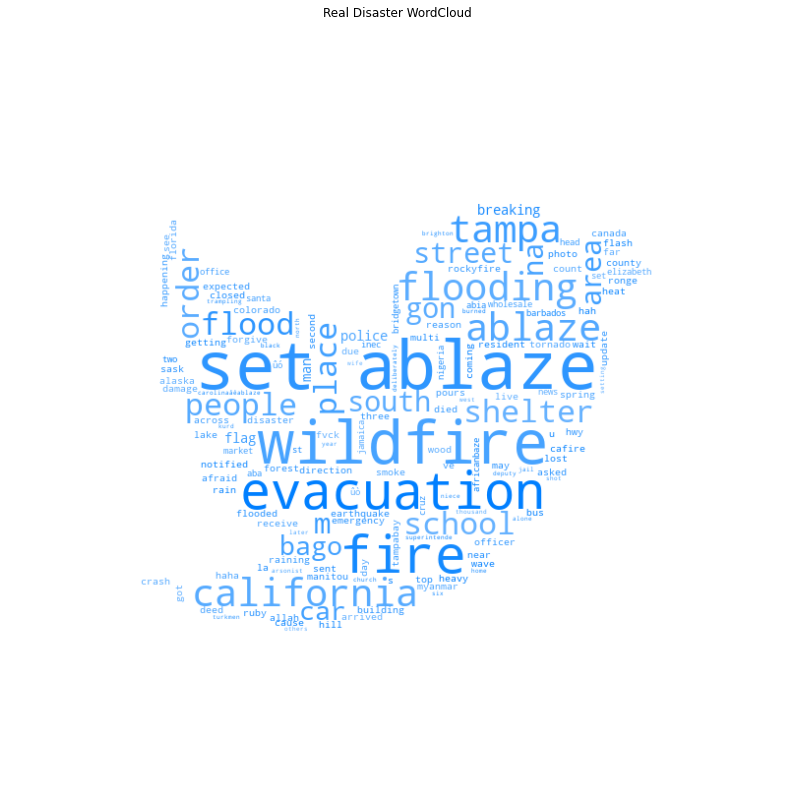

In [21]:
# Instantiate the Twitter word cloud object
twitter_wc = WordCloud(background_color='white', max_words=500, mask=image)

# generate the word cloud
twitter_wc.generate(" ".join(corpus_real_disaster[:200]))

# display the word cloud
fig = plt.figure()
fig.set_figwidth(14)  # set width
fig.set_figheight(18)  # set height
plt.imshow(twitter_wc.recolor(color_func=blue_color_func, random_state=3),
           interpolation="bilinear")
plt.axis('off')
plt.title('Real Disaster WordCloud')
plt.show()

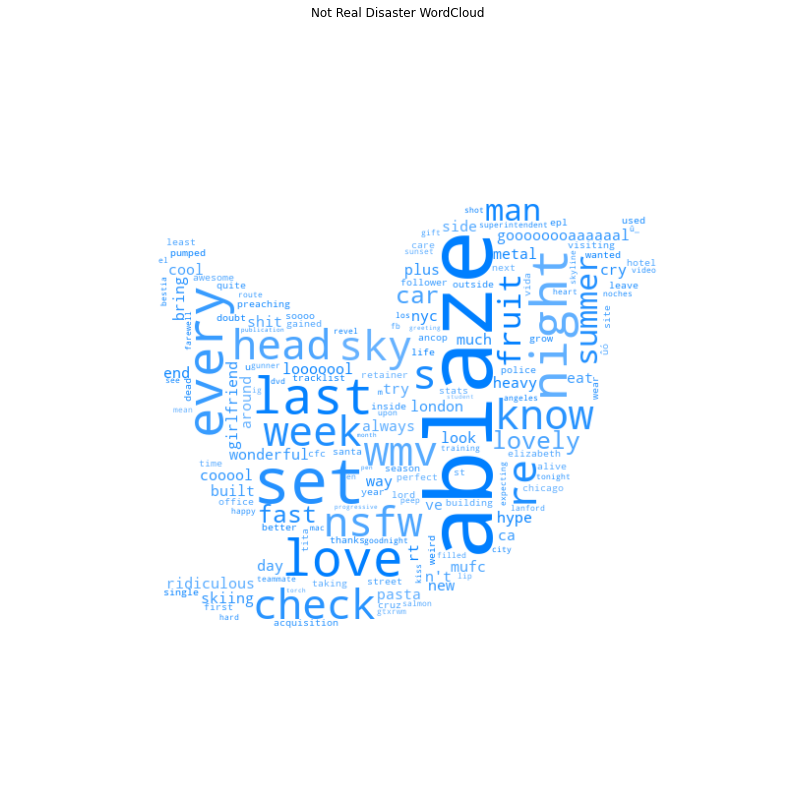

In [22]:
# Instantiate the Twitter word cloud object
twitter_wc = WordCloud(background_color='white', max_words=500, mask=image)

# generate the word cloud
twitter_wc.generate(" ".join(corpus_not_real_disaster[:200]))

# display the word cloud
fig = plt.figure()
fig.set_figwidth(14)  # set width
fig.set_figheight(18)  # set height
plt.imshow(twitter_wc.recolor(color_func=blue_color_func, random_state=3),
           interpolation="bilinear")
plt.axis('off')
plt.title('Not Real Disaster WordCloud')
plt.show()

### Cheking data after cleaning

I think it is also important to check the distribution of the words in tweet after the cleaning, sicne now we are facing with the data we are going to feed into the model.

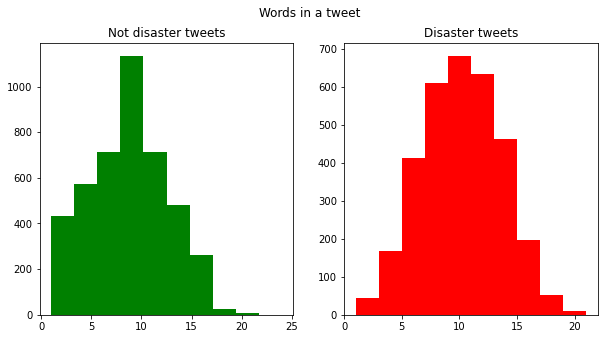

In [23]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(10,5))
tweet_len=df_tweets[df_tweets['target']==0]['Processed_Tweets'].str.split().map(lambda x: len(x))
ax1.hist(tweet_len,color='green')
ax1.set_title('Not disaster tweets')
tweet_len=df_tweets[df_tweets['target']==1]['Processed_Tweets'].str.split().map(lambda x: len(x))
ax2.hist(tweet_len,color='red')
ax2.set_title('Disaster tweets')
fig.suptitle('Words in a tweet')
plt.show()

In [24]:
#Cheking that there are no rows where all data have been removed during cleaning
tweet_len_not_disaster=df_tweets[df_tweets['target']==0]['Processed_Tweets'].str.split().map(lambda x: len(x))
tweet_len_disaster=df_tweets[df_tweets['target']==1]['Processed_Tweets'].str.split().map(lambda x: len(x))
if (tweet_len_not_disaster == 0).sum() != 0 or (tweet_len_disaster == 0).sum() !=0 :
    print('We have rows where all words disappeared!')

As we can see the distribution are still similar and there is no any rows where all words have been removed during cleaning.

### Model Training - Using pre-trained BERT

In [25]:
#separating targets and tweets to different variables for training
X = df_tweets.drop(['id','keyword','location','text','target'],1)
y = df_tweets['target']

In [26]:
#splitting the training dataset into training and validation set by 0.8/0.2
X_train, X_val, y_train, y_val = train_test_split(X,y, test_size=0.2, random_state = 12)
X_train = X_train['Processed_Tweets'].tolist() #this is neccessary because we need list when we apply tokenizer
X_val = X_val['Processed_Tweets'].tolist() #this is neccessary because we need list when we apply tokenizer

In [27]:
len(X_train), len(y_train)

(6090, 6090)

In [28]:
#download the pre-trained tokenizer - IMPORTANT: this convert raw text into numerical data
tokenizer = DistilBertTokenizerFast.from_pretrained('distilbert-base-uncased')

In [29]:
#function to use tokennizer
def tokenize_tweets(tweet):
    encoded = tokenizer(tweet,padding=True,truncation=True,return_tensors='np')
    return encoded.data

In [30]:
#applying tokenizer
tokenized_X_train = tokenize_tweets(X_train)
tokenized_X_val = tokenize_tweets(X_val)

In [31]:
#download the pre-trained model
model = TFDistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased')

Some layers from the model checkpoint at distilbert-base-uncased were not used when initializing TFDistilBertForSequenceClassification: ['vocab_transform', 'vocab_projector', 'activation_13', 'vocab_layer_norm']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFDistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier', 'pre_classifier', 'dropout_19']
You should probably TRAIN this model on a down-stream task to be able to use i

#### This error code is appearing beacuse we use a pre-pretrained model that we have to fine tune to get better results!!!

In [32]:
#setup the model for training
model.compile(Adam(lr=1e-5), loss=model.compute_loss,metrics=['accuracy'])
model.fit(
        tokenized_X_train,
        np.array(y_train),
        validation_data=(
            tokenized_X_val,
            np.array(y_val),
        ),
        batch_size=32, epochs=5
)

C:\Users\Lenovo\anaconda3\lib\site-packages\keras\optimizer_v2\optimizer_v2.py:355: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


Epoch 1/5
191/191 [==============================] - 494s 3s/step - loss: 0.4918 - accuracy: 0.7685 - val_loss: 0.4167 - val_accuracy: 0.8181
Epoch 2/5
191/191 [==============================] - 539s 3s/step - loss: 0.3731 - accuracy: 0.8450 - val_loss: 0.4081 - val_accuracy: 0.8267
Epoch 3/5
191/191 [==============================] - 579s 3s/step - loss: 0.3209 - accuracy: 0.8713 - val_loss: 0.4158 - val_accuracy: 0.8306
Epoch 4/5
191/191 [==============================] - 558s 3s/step - loss: 0.2726 - accuracy: 0.8961 - val_loss: 0.4275 - val_accuracy: 0.8365
Epoch 5/5
191/191 [==============================] - 549s 3s/step - loss: 0.2189 - accuracy: 0.9167 - val_loss: 0.4836 - val_accuracy: 0.8253


#### Final accuracy on validation set is 83%!!!

In [33]:
#saving the model
model.save_pretrained('finetuned_bert_model_for_tweet_analysis')

### Applying the same text processing steps on the test set

In [34]:
test_tweets.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


In [35]:
test_tweets['Processed_Tweets'] = test_tweets['text'].apply(preprocessTweets)
test_tweets['Processed_Tweets'] = test_tweets['Processed_Tweets'].apply(preprocessTweetsLemmatizer)
test_tweets.head()

,id,keyword,location,text,Processed_Tweets
0,0,NaN,NaN,Just happened a terrible car crash,happened terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s...",heard earthquake different city stay safe ever...
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are...",forest fire spot pond goose fleeing across str...
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires,apocalypse lighting spokane wildfire
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan,typhoon soudelor kill china taiwan


In [36]:
#removing other columns, convert to list and tokenization
test_ = df_tweets.drop(['id','keyword','location','text','target'],1)
test_ = test_['Processed_Tweets'].tolist()
tokenized_test_ = tokenize_tweets(test_)

### Prediction 

In [37]:
#predicting the values for test set
test_predictions = model.predict(tokenized_test_)

In [59]:
#final results
import tensorflow
probabilities = tensorflow.nn.softmax(test_predictions.logits, name = 'Predictions')

In [70]:
final_results = np.argmax(probabilities,1)

In [72]:
final_results

array([0, 1, 1, ..., 1, 1, 1], dtype=int64)